# Importing Pandas, NLTK, NUMPY, PATHLIB, JOBLIB,TQDM

In [30]:
import pandas as pd
import nltk
import numpy as np
import pathlib
import joblib
import tqdm
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
''''from nltk.stem.lancaster import LancasterStemmer'''
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
''''from sklearn.feature_extraction.text import CountVectorizer'''
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [31]:
# for reproducability
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

# Reading datasets

In [4]:
ground_truth=pd.read_csv('dev-set_ground-truth.csv')
caption=pd.read_csv('dev-set_video-captions.csv')
print(list(ground_truth.columns.values))

['video', 'short-term_memorability', 'nb_short-term_annotations', 'long-term_memorability', 'nb_long-term_annotations']


# Merging Files

In [32]:
ground_truth_caption = pd.merge(ground_truth, caption, on = 'video')
ground_truth_caption.head(10)

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations,caption
0,video3.webm,0.924,34,0.846,13,blonde-woman-is-massaged-tilt-down
1,video4.webm,0.923,33,0.667,12,roulette-table-spinning-with-ball-in-closeup-shot
2,video6.webm,0.863,33,0.700,10,khr-gangsters
3,video8.webm,0.922,33,0.818,11,medical-helicopter-hovers-at-airport
4,video10.webm,0.950,34,0.900,10,couple-relaxing-on-picnic-crane-shot
5,video12.webm,0.783,74,0.750,12,passing-by-older-man-reading
6,video13.webm,0.861,40,0.700,10,christmas-village-and-national-christmas-tree
7,video16.webm,0.834,33,0.857,14,unhappy-friends-looking-for-something-interest...
8,video17.webm,0.777,43,1.000,11,hoover-dam-tourists-traffic
9,video18.webm,0.863,33,1.000,9,happy-girl-stretching-and-relaxing-on-the-station


# Function for Part of speech Tagging

In [33]:
lemmatizer = WordNetLemmatizer() 
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


# Cleaning captions through tokenization, stopwords removal, lemmatization and POS

In [34]:
cleaned_caption=[]

for index,row in ground_truth_caption.iterrows():
    tokens=(row['caption'].split('-'))
    stopWords = set(stopwords.words('english'))
    rm_stopwords= [w for w in tokens if not w in stopWords]
    ''''lanste = LancasterStemmer()
    stemming = [lanste.stem(i) for i in rm_stopwords]'''
    lemmatization=' '.join([lemmatizer.lemmatize(word , get_wordnet_pos(word)) for word in rm_stopwords if word])
    cleaned_caption.append(lemmatization)
ground_truth_caption['cleaned_caption']=pd.Series(cleaned_caption)
ground_truth_caption.head(10)


,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations,caption,cleaned_caption
0,video3.webm,0.924,34,0.846,13,blonde-woman-is-massaged-tilt-down,blonde woman massage tilt
1,video4.webm,0.923,33,0.667,12,roulette-table-spinning-with-ball-in-closeup-shot,roulette table spin ball closeup shot
2,video6.webm,0.863,33,0.700,10,khr-gangsters,khr gangster
3,video8.webm,0.922,33,0.818,11,medical-helicopter-hovers-at-airport,medical helicopter hovers airport
4,video10.webm,0.950,34,0.900,10,couple-relaxing-on-picnic-crane-shot,couple relax picnic crane shot
5,video12.webm,0.783,74,0.750,12,passing-by-older-man-reading,passing old man reading
6,video13.webm,0.861,40,0.700,10,christmas-village-and-national-christmas-tree,christmas village national christmas tree
7,video16.webm,0.834,33,0.857,14,unhappy-friends-looking-for-something-interest...,unhappy friend look something interest television
8,video17.webm,0.777,43,1.000,11,hoover-dam-tourists-traffic,hoover dam tourist traffic
9,video18.webm,0.863,33,1.000,9,happy-girl-stretching-and-relaxing-on-the-station,happy girl stretch relax station


# Applying TF-IDF Vectorizer

In [10]:
vectorizer=TfidfVectorizer(max_features=1000)
response=vectorizer.fit_transform(ground_truth_caption.cleaned_caption).toarray()
print(len(vectorizer.get_feature_names()))
print(response)

1000
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Merging Vectorized caption in the ground truth

In [11]:
ground_truth_caption['Vectorized_Caption']=pd.Series(response.tolist())
print(ground_truth_caption.head(10))

          video  short-term_memorability  nb_short-term_annotations  \
0   video3.webm                    0.924                         34   
1   video4.webm                    0.923                         33   
2   video6.webm                    0.863                         33   
3   video8.webm                    0.922                         33   
4  video10.webm                    0.950                         34   
5  video12.webm                    0.783                         74   
6  video13.webm                    0.861                         40   
7  video16.webm                    0.834                         33   
8  video17.webm                    0.777                         43   
9  video18.webm                    0.863                         33   

   long-term_memorability  nb_long-term_annotations  \
0                   0.846                        13   
1                   0.667                        12   
2                   0.700                        10  

# Function to read C3D feature

In [12]:
def read_C3D(fname):
    """Scan vectors from file"""
    with open(fname) as f:
        for line in f:
            C3D =[float(item) for item in line.split()] # convert to float type, using default separator
    return C3D
c3d_path = Path('C3D')
max_iterations = 6000
c3d_feat_dict ={}

for file in tqdm (list(c3d_path.glob('*.txt'))):
  key = file.with_suffix('.webm').name
  c3d_feat_dict[key] = read_C3D(file)

# Converting C3D dict into the Dataframe

In [14]:
 c3d_feat= pd.DataFrame(c3d_feat_dict).T
c3d_feat=pd.DataFrame(c3d_feat).rename_axis('video')
c3d_feat.head(10)

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
video,,,,,,,,,,,,,,,,,,,,,
video10.webm,0.000090,6.149400e-04,3.436340e-03,1.280920e-03,3.551400e-03,3.128800e-04,4.187000e-05,1.821000e-05,1.574100e-04,1.171300e-04,...,3.731000e-05,6.900100e-04,1.708900e-04,0.000231,6.371500e-04,4.001000e-05,6.142000e-05,7.549000e-05,2.490000e-06,0.001323
video100.webm,0.002312,9.965510e-03,2.743902e-02,5.850000e-06,2.155300e-04,1.394600e-04,1.109700e-04,2.914000e-05,4.636000e-05,2.388820e-03,...,3.257860e-03,1.226390e-03,3.939800e-04,0.008439,1.255300e-04,1.976800e-04,1.048400e-04,7.504678e-02,2.875732e-01,0.003510
video1001.webm,0.468035,4.895013e-01,7.944000e-05,9.680000e-06,2.000000e-07,1.540000e-06,1.678300e-04,1.044000e-05,3.437000e-05,5.200000e-07,...,2.011000e-05,1.300000e-07,7.000000e-08,0.000006,1.790000e-06,9.200000e-07,1.950000e-06,1.269800e-04,7.140700e-04,0.000408
video1003.webm,0.014036,4.922300e-04,2.331100e-04,2.793000e-05,6.320000e-06,1.330000e-06,5.740000e-06,2.310000e-06,6.950000e-06,4.002000e-05,...,9.199000e-05,4.673000e-05,1.878000e-05,0.000049,3.068000e-05,1.310000e-06,7.410000e-06,8.304563e-01,2.718730e-03,0.001101
video1004.webm,0.046734,8.678200e-04,5.250000e-06,8.050000e-06,2.000000e-08,5.600000e-07,1.303000e-05,3.770000e-06,1.300000e-06,5.990000e-06,...,1.574000e-05,1.000000e-08,4.500000e-07,0.000004,2.400000e-07,1.100000e-07,3.300000e-07,1.710000e-06,1.786000e-05,0.000080
video1005.webm,0.001117,1.738200e-04,4.184700e-04,6.000000e-08,1.860000e-06,1.420000e-05,4.400000e-07,2.800000e-07,8.500000e-06,6.245000e-05,...,6.720000e-06,8.000000e-08,4.770000e-06,0.000060,7.370000e-06,8.000000e-08,5.610000e-06,4.363580e-03,4.743000e-05,0.003046
video1006.webm,0.000164,2.400000e-07,6.297130e-03,1.290000e-06,6.800000e-07,4.982800e-04,2.500000e-07,4.000000e-07,1.860000e-06,6.440000e-06,...,4.000000e-08,3.000000e-08,1.770000e-06,0.000004,3.000000e-07,6.000000e-08,8.300000e-07,8.400000e-07,5.000000e-08,0.016884
video1007.webm,0.001026,2.651200e-04,8.154200e-04,5.820000e-06,3.110000e-06,2.380000e-06,2.566600e-04,9.307700e-04,1.707200e-04,6.770000e-06,...,4.704400e-04,9.100000e-07,7.900000e-07,0.051365,2.464000e-05,9.946000e-05,7.960000e-06,3.745000e-05,9.155220e-01,0.000404
video1009.webm,0.002343,6.207250e-03,9.056000e-05,2.099000e-05,5.590000e-06,2.181000e-05,1.928000e-05,2.805500e-04,3.367000e-05,2.834000e-05,...,1.831760e-03,8.580000e-05,4.119200e-04,0.011116,1.680800e-04,6.100000e-07,2.230200e-04,3.557000e-05,7.922000e-05,0.004707


# Merging Vectorized Caption and C3D into a Video Features dataframe

In [15]:
video_features=pd.DataFrame(ground_truth_caption['Vectorized_Caption'].tolist())
video_features['video']=pd.Series(ground_truth_caption['video'])
video_features=pd.merge(video_features, c3d_feat, on = 'video')

print(video_features.head(10))

   0_x  1_x  2_x  3_x  4_x  5_x  6_x  7_x  8_x  9_x      ...       \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      ...        
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      ...        
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      ...        
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      ...        
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      ...        
5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      ...        
6  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      ...        
7  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      ...        
8  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      ...        
9  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      ...        

           91_y          92_y          93_y          94_y      95_y  \
0  1.041650e-03  1.613500e-04  2.571600e-04  4.661711e-02  0.000156   
1  5.821200e-04  3.925200e-04  8.639800e-04  9.472300e-04  0.000136   
2  2.240800e-04  2.590000e-

# Function for calculating Spearmann's correlation coefficient

In [16]:
def Get_score(Y_pred,Y_true):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score(Y_pred[:,ii],Y_true[:,ii])

# Function for visualizing the acutual score and predicted score

In [17]:
def visualize_pred(y_pred, y_test,model_name,key):
    """
        Visualize predicted result for 100 randomly selected samples
    """
    vis_lst = [i for i in range(len(y_pred))]
    np.random.shuffle(vis_lst)
    y_test = y_test.reset_index()

    fig, ax = plt.subplots(figsize=(12,3))
    ax.set(xlabel='Samples', ylabel='Memorability_Score',
           title='Predicted and Actual score comparison on 100 random samples using ' + model_name)
    ax.plot(range(len(y_pred[vis_lst[:100]])),y_pred[vis_lst[:100]])
    if(key=='short-term_memorability'):
      ax.plot(range(len(y_test.loc[vis_lst[:100],'short-term_memorability'])),y_test.loc[vis_lst[:100],'short-term_memorability'])
      
    if(key=='long-term_memorability'):
      ax.plot(range(len(y_test.loc[vis_lst[:100],'long-term_memorability'])),y_test.loc[vis_lst[:100],'long-term_memorability'])
    
    ax.legend(('Predicted Score', 'Actual Score'),
               loc='upper left')
    ax.grid(),
    plt.show()

# Assigning X and Y for label for short-term memorability

In [18]:
X=video_features.iloc[:,1:]
X=X.loc[:, X.columns != 'video']

X['nb_short-term_annotations']=pd.Series(ground_truth_caption['nb_short-term_annotations'])
X.shape
Y=pd.DataFrame(ground_truth_caption['short-term_memorability'])
print(X.head(10))


   1_x  2_x  3_x  4_x  5_x  6_x  7_x  8_x  9_x  10_x  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   
5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   
6  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   
7  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   
8  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   
9  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   

             ...                      92_y          93_y          94_y  \
0            ...              1.613500e-04  2.571600e-04  4.661711e-02   
1            ...              3.925200e-04  8.639800e-04  9.472300e-04   
2            ...              2.590000e-06  3.066000e-05  2.538240e-03   
3            ...              8.730000e-06  2.278000e-05  5.279000e-05   
4            

# Dividing the Data into Test and Train Data in 80% and 20% respectively

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

seed = 7
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

# Standard Deviation of train and test data for short term memorability 

In [20]:
print(np.std(y_train))
print(np.std(y_test))

short-term_memorability    0.081254
dtype: float64
short-term_memorability    0.078168
dtype: float64


# Applying XGBoost Model to get Rmse and Spearman's correlation coefficient for short term memorability

RMSE =  0.0717882924008552
The Spearman's correlation coefficient is: 0.382


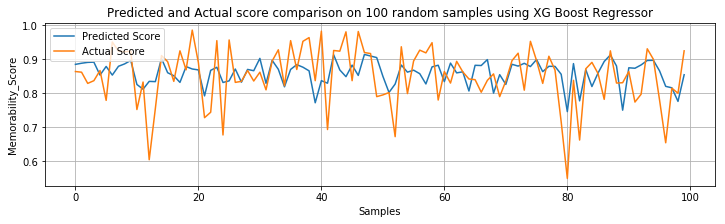

In [21]:
from xgboost import XGBRegressor
short_term_opt_params = {'booster' : 'gbtree', 'max_depth' :12,'n_estimator' :1000}
xgb_short = XGBRegressor(**short_term_opt_params)
xgb_short.fit(X_train, y_train, eval_metric = 'rmse')
y_pred_short = xgb_short.predict(X_test)
#print('RMSE = ',cal_rmse(y_pred_short, y_test))
rms = sqrt(mean_squared_error(y_test, y_pred_short))
print('RMSE = ',rms)
Get_score(y_pred_short, y_test)
#print('RMSE = ',np.sqrt(np.sum((y_pred_short - y_test)**2 / len(y_pred_short))))
visualize_pred(y_pred_short, y_test, 'XG Boost Regressor','short-term_memorability')

# Assigning X and Y for long term memorability 

In [22]:

X=video_features.iloc[:, video_features.columns != 'video']
X=X.loc[:, X.columns != 'video']
X['nb_long-term_annotations']=pd.Series(ground_truth_caption['nb_long-term_annotations'])
Y=pd.DataFrame(ground_truth_caption['long-term_memorability'])
print(X.head(10))

   0_x  1_x  2_x  3_x  4_x  5_x  6_x  7_x  8_x  9_x            ...             \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0            ...              
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0            ...              
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0            ...              
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0            ...              
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0            ...              
5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0            ...              
6  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0            ...              
7  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0            ...              
8  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0            ...              
9  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0            ...              

           92_y          93_y          94_y      95_y          96_y      97_y  \
0  1.613500e-04  2.571600e-

# Standard deviation of test and train dataset for long term memorability

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
print(np.std(y_train))
print(np.std(y_test))

long-term_memorability    0.145299
dtype: float64
long-term_memorability    0.142112
dtype: float64


# Applying XGBoost to calculate RMSE and Spearman's correlation coefficient for long term memorability

RMSE =  0.1422976425152621
The Spearman's correlation coefficient is: 0.172


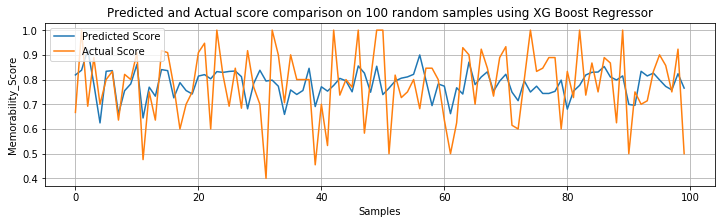

In [24]:
long_term_opt_params = {'booster' : 'gbtree', 'max_depth' : 12, 'n_estimator' : 2000}
xgb_long = XGBRegressor(**long_term_opt_params)
xgb_long.fit(X_train, y_train, eval_metric = 'rmse')
y_pred_long = xgb_long.predict(X_test)
#print('RMSE = ',cal_rmse(y_pred_short, y_test))
rms = sqrt(mean_squared_error(y_test, y_pred_long))
print('RMSE = ',rms)
Get_score(y_pred_long, y_test)
#print('RMSE = ',np.sqrt(np.sum((y_pred_short - y_test)**2 / len(y_pred_short))))
visualize_pred(y_pred_long, y_test, 'XG Boost Regressor','long-term_memorability')

# Saving model for both short and long term memorability 

In [25]:
joblib.dump(xgb_short, 'Model/xgb_short.xgb')
joblib.dump(xgb_long, 'Model/xgb_long.xgb')

['Model/xgb_long.xgb']